In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [2]:
# cora = pd.read_csv("../Embeddings/Cora_dataset_EMBS.csv")
cora = pd.read_csv("../models/Cora_dataset_new_clsBERT.csv")
cora_citations  = pd.read_csv("../cora_extracted/cora_orig/cora.cites", 
                       sep="\t",       
                       header=None,    
                       names=["source", "target"])  

print(cora_citations.head())
print(f"Number of edges: {len(cora_citations)}") # original number of edges

   source   target
0      35     1033
1      35   103482
2      35   103515
3      35  1050679
4      35  1103960
Number of edges: 5429


In [3]:
valid_ids = cora.iloc[:, 0].tolist()

filtered_cites = cora_citations[
    cora_citations["source"].isin(valid_ids) & cora_citations["target"].isin(valid_ids)]

In [5]:
print(filtered_cites.head())
print(f"Number of edges: {len(filtered_cites)}") 

   source   target
0      35     1033
1      35   103482
2      35   103515
4      35  1103960
5      35  1103985
Number of edges: 4261


### **Create the incidence matrix**

In [6]:
outgoing = cora_citations.groupby('source')['target'].apply(set).to_dict()
incoming = cora_citations.groupby('target')['source'].apply(set).to_dict()

nodes = set(cora_citations['source']).union(cora_citations['target'])

hyperedges = {}

for node in nodes:
    cites = outgoing.get(node, set())
    cited_by = incoming.get(node, set())
    hyperedges[node] = cites.union(cited_by)


print(hyperedges)

{851968: {278394, 230879, 1140231}, 1114118: {119712, 910}, 1114125: {128, 114}, 950305: {739707, 1365}, 262178: {1138968, 85449, 1114442}, 35: {66563, 1128453, 1127430, 1033, 1125386, 573964, 66556, 634902, 634904, 1128985, 568857, 573978, 128540, 141342, 45599, 141347, 206371, 1131557, 178727, 1153065, 1153577, 287787, 84021, 1050679, 574009, 103482, 1129018, 634938, 1129027, 608326, 735303, 787016, 503883, 249421, 592973, 503893, 427606, 561238, 1103960, 103515, 634975, 1129573, 575077, 248425, 640617, 1131116, 263279, 33904, 1103985, 594543, 33907, 259701, 259702, 48766, 594047, 1154176, 28290, 1133196, 18582, 1688, 646809, 8865, 69284, 513189, 1136814, 1120431, 69296, 78511, 82098, 28851, 646837, 175291, 593091, 132806, 148170, 577227, 1109199, 593105, 1129683, 387795, 576725, 594649, 1114331, 578780, 1113831, 1131752, 190697, 647408, 190706, 41714, 35061, 66805, 1153280, 273152, 229635, 1128204, 1119505, 647447, 1133338, 576795, 12576, 1128227, 1117476, 286500, 198443, 1129778, 1

In [7]:
def parse_embedding_flexible(s):
    if isinstance(s, str):
        s = s.replace('[', '').replace(']', '').replace('\n', ' ')
        s = s.replace(',', ' ')
        return np.array([float(x) for x in s.split() if x.strip() != ''])
    elif isinstance(s, (list, np.ndarray)):
        return np.array(s)
    else:
        return np.nan

# Apply to all Embedding columns
for col in ["bert_cls_embedding2"]:
    cora[col] = cora[col].apply(parse_embedding_flexible)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder


nodes_list = [n for n in nodes]
subset = cora[cora["paper_id"].isin(nodes_list)]
embs = np.vstack(subset["bert_cls_embedding2"].values)

scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs)

pca = PCA(n_components=3)
embs_3d = pca.fit_transform(embs_scaled)

node_to_coord = {node: emb for node, emb in zip(nodes_list, embs_3d)}

le = LabelEncoder()
cora['label_encoded'] = le.fit_transform(cora['topic2'])
y_labels = subset["label_encoded"].values
class_names = le.classes_

colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
node_colors = [colors[label] for label in y_labels]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(embs_3d[:, 0], embs_3d[:, 1], embs_3d[:, 2],
           c=node_colors, s=100, edgecolor='k', alpha=0.9)


for node, neighbors in hyperedges.items():
    if node not in node_to_coord:
        continue  

    for nbr in neighbors:
        if nbr not in node_to_coord:
            continue  

        x = [node_to_coord[node][0], node_to_coord[nbr][0]]
        y = [node_to_coord[node][1], node_to_coord[nbr][1]]
        z = [node_to_coord[node][2], node_to_coord[nbr][2]]

        ax.plot(x, y, z, c='gray', alpha=0.25, lw=1)

ax.set_title("3D Hypergraph Visualization of Node Embeddings", fontsize=16)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

for class_idx, class_name in enumerate(class_names):
    ax.scatter([], [], [], c=[colors[class_idx]], label=class_name)
ax.legend(title="Topics")

plt.show()


In [9]:
d = dict()
for node, nbr in hyperedges.items():
    if node == 35:
        d[35] = nbr

s = list()
for k, v in d.items():
    s.append(k)
    for val in v:
        s.append(val)
len(s)

169

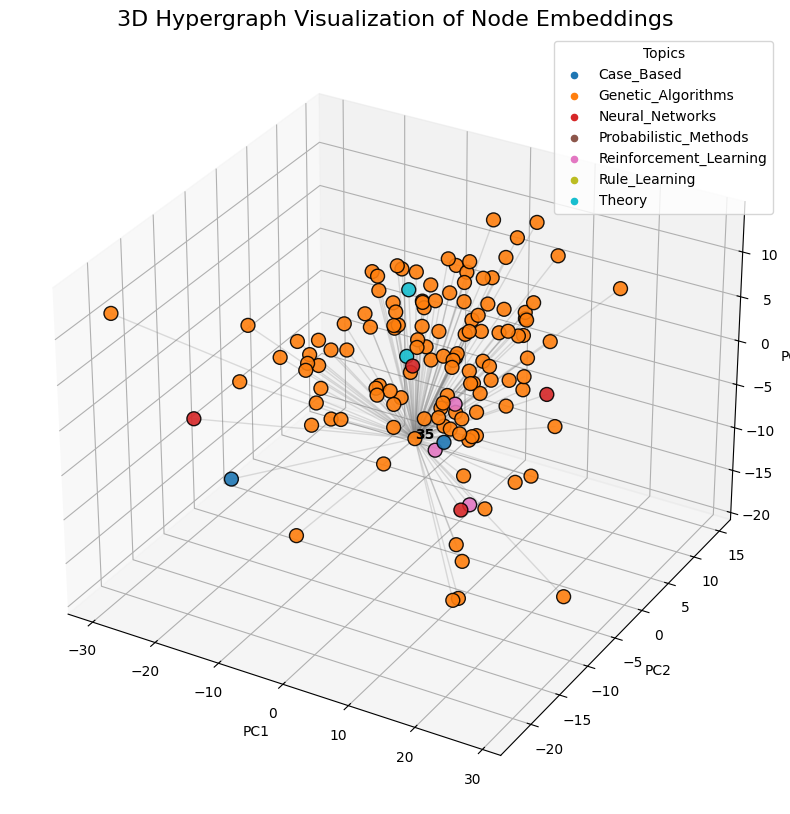

In [11]:
nodes_list = s
subset = cora[cora["paper_id"].isin(nodes_list)]
embs = np.vstack(subset["bert_cls_embedding2"].values)


scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs)

pca = PCA(n_components=3)
embs_3d = pca.fit_transform(embs_scaled)

node_to_coord = {node: emb for node, emb in zip(nodes_list, embs_3d)}

le = LabelEncoder()
cora['label_encoded'] = le.fit_transform(cora['topic2'])
y_labels = subset["label_encoded"].values
class_names = le.classes_

colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
node_colors = [colors[label] for label in y_labels]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
ax.scatter(embs_3d[:, 0], embs_3d[:, 1], embs_3d[:, 2],
           c=node_colors, s=100, edgecolor='k', alpha=0.9)

for node, neighbors in d.items():
    if node not in node_to_coord:
        continue 

    for nbr in neighbors:
        if nbr not in node_to_coord:
            continue  

        x = [node_to_coord[node][0], node_to_coord[nbr][0]]
        y = [node_to_coord[node][1], node_to_coord[nbr][1]]
        z = [node_to_coord[node][2], node_to_coord[nbr][2]]

        ax.plot(x, y, z, c='gray', alpha=0.25, lw=1)

# annotate node 35
for node, coord in node_to_coord.items():
    if node == 35:
        ax.text(coord[0], coord[1], coord[2], str(node), fontsize=10, fontweight='bold', color='black')

ax.set_title("3D Hypergraph Visualization of Node Embeddings", fontsize=16)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Legend for classes
for class_idx, class_name in enumerate(class_names):
    ax.scatter([], [], [], c=[colors[class_idx]], label=class_name)
ax.legend(title="Topics")

plt.show()


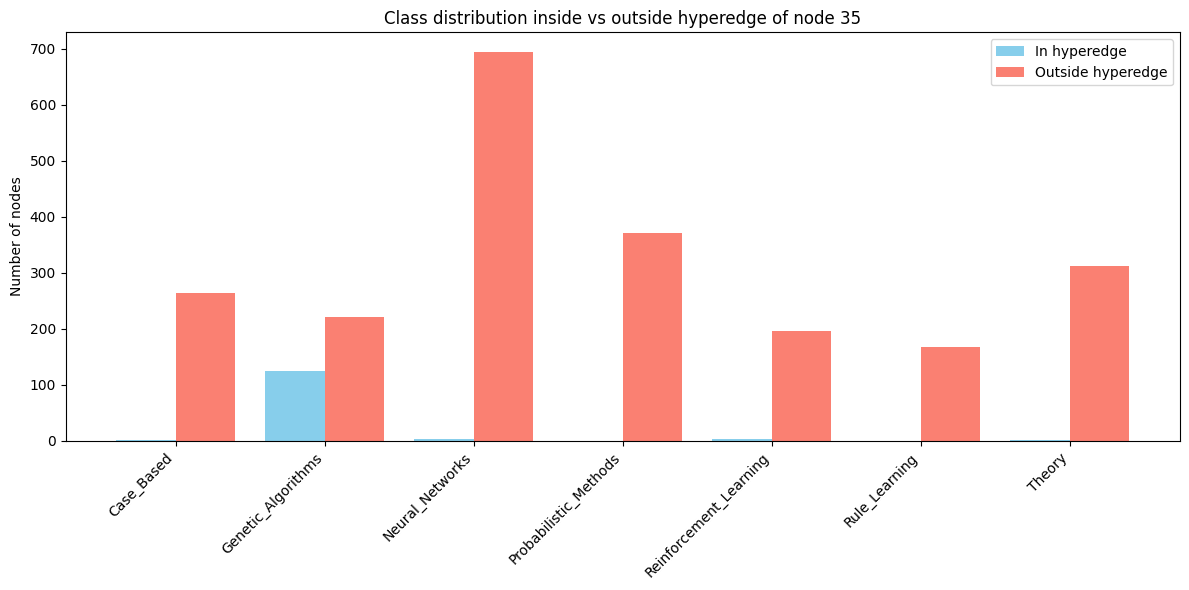

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

hyperedge_35 = set(d[35])
hyperedge_35.add(35)

nodes_in_hyperedge = [n for n in all_nodes if n in hyperedge_35]
nodes_out_hyperedge = [n for n in all_nodes if n not in hyperedge_35]

classes_in = cora.loc[cora['paper_id'].isin(nodes_in_hyperedge), 'topic2'].values
classes_out = cora.loc[cora['paper_id'].isin(nodes_out_hyperedge), 'topic2'].values
count_in = Counter(classes_in)
count_out = Counter(classes_out)

all_classes = sorted(list(set(classes_in) | set(classes_out)))
in_values = [count_in.get(c, 0) for c in all_classes]
out_values = [count_out.get(c, 0) for c in all_classes]
x = range(len(all_classes))
width = 0.4

fig, ax = plt.subplots(figsize=(12,6))
ax.bar([i - width/2 for i in x], in_values, width=width, label='In hyperedge', color='skyblue')
ax.bar([i + width/2 for i in x], out_values, width=width, label='Outside hyperedge', color='salmon')
ax.set_xticks(x)
ax.set_xticklabels(all_classes, rotation=45, ha='right')
ax.set_ylabel('Number of nodes')
ax.set_title('Class distribution inside vs outside hyperedge of node 35')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import json
hypergraphs_json = {k: list(v) for k, v in hyperedges.items()}

with open('hyperedges_cora.json', 'w', encoding='utf-8') as f:
    json.dump(hypergraphs_json, f, indent=2, ensure_ascii=False)
